This notebook allows for wholistic qualitative and quantitative evaluation of nuclear segmentation performance of multiple segmentation platforms on multiple regions/fields from different whole slide images. Prior to running this notebook, ensure that binary nuclear masks have been generated for all the fields you have sampled from the dataset. Instructions for this can be found in the `segmentation` module of the repository. There should be one binary mask from each segmentation platform for a field. Next, put all the binary masks for one field in a directory, and all the binary masks for another field in a different directory. As a result, there should be one directory for each field, where the directories contain the binary nuclear masks from the platforms being evaluated. Please note that all masks should be tiff files.

The next step is to select four 256X256 pixel sub-fields for evaluation from each field and record their coordinates. Ground truth nuclear annotations can then be created in GIMP for the subfields. Two of these regions should be selected for sparse while the other two for densely populated regions of nuclei to evaluate nuclear segmentation over a range of nuclear density (if possible). Effort should also made to sample one sub-region from each of the four quadrants of the fields to ensure exhaustive spatial sampling for evaluation.

In GIMP, load the gray scaled DAPI channel for the field and crop the image according to the coordinates for the first evaluation sub-field. Add a new layer over the DAPI image with a medium level of opacity so that the DAPI signal can still be clearly visualized by the annotators. The boundaries of nuclei can then annotated using a 1x1 pixel square brush and filled in with a bucket fill tool of white (foreground). A 2x2 square pixel brush of black (background) must used to add a dividing line between touching nuclei. The DAPI signal layer is then hidden and the opacity of the annotated binary mask layer can be turned to 100% prior to exporting the ground truth binary mask. Repeat this process for all evaluation subfields from all WSI fields.

As a result, there should be one directory for each field, where the directories contain four ground truth binary nuclear masks, one for each evaluation sub-field. Please note that all masks should be tiff files.

The recommended file structure for storing the segmentation platform-derived nuclear binary masks and the ground truth masks are as follows:

```
root
|Fields
||-Field1
|||-Platforms
||||-Platform1.tiff
||||-Platform2.tiff
||||-Platform3.tiff
|||-ground_truth
||||-gr_tr_sparse1.tiff
||||-gr_tr_sparse2.tiff
||||-gr_tr_dense1.tiff
||||-gr_tr_dense2.tiff
||-Field2
|||-Platforms
||||-Platform1.tiff
||||-Platform2.tiff
||||-Platform3.tiff
|||-ground_truth
||||-gr_tr_sparse1.tiff
||||-gr_tr_sparse2.tiff
||||-gr_tr_dense1.tiff
||||-gr_tr_dense2.tiff
```

'Field1' and 'Field2' can be replaced with custom names for identifying and distinguishing the different fields being used. Build the directory structure for as many whole slide image fields/regions and platforms as required. Storing the binary masks with this file structure will allow compatibility with the evaluation code below. The file structure above will also be referenced in the code below for ease of use.

In [1]:
from F1_calc import halfIoUThresh
from F1_calc import multipleIoUThresh
from F1_calc import csv_viz_halfIoU
from F1_calc import csv_viz_multipleIoU

In [2]:
root_dir = r"C:\Users\mrl\Desktop\nuclear_seg_github\root" # "Root" in the file structure above

# The top-left coordinates of four evaluatory sub-fields in each of five example fields are used
# Field 1
Bph2_45174_14597_coord_dict = {'sparse1': (246, 160),'dense1': (682, 2492), 'sparse2': (2420, 3625), 'dense2': (2032, 2032)}
# Field 2
sixplexTonsil_10122021_coord_dict = {'sparse1': (1140, 351), 'sparse2': (1053, 1416), 'dense1': (23, 1589), 'dense2': (14, 16)}
# Field 3
TME11_12154_44141_coord_dict = {'sparse1': (0, 1378),'dense1': (434, 691), 'sparse2': (1092, 231), 'dense2': (704, 939)}
# Field 4
Tonsil_7color_Scan2_17096_47011_coord_dict = {'sparse1': (103, 57), 'sparse2': (914, 627), 'dense1': (1140, 1044), 'dense2': (232, 1304)}
# Field 5
VISTA4_47265_15281_coord_dict = {'sparse1': (668, 1670), 'dense1': (2464, 2409), 'sparse2': (2272, 1830), 'dense2': (239, 2323)}
# Creating a master dictionary. The keys should correspond exactly with the name of the directories "Field1", "Field2", etc. in the file
# structure above
regions_coordinate_dict = {'Bph2_45174_14597': Bph2_45174_14597_coord_dict,
                          'sixplexTonsil_10122021': sixplexTonsil_10122021_coord_dict,
                          'TME11_12154_44141': TME11_12154_44141_coord_dict,
                          'Tonsil_7color_Scan2_17096_47011': Tonsil_7color_Scan2_17096_47011_coord_dict,
                          'VISTA4_47265_15281':VISTA4_47265_15281_coord_dict}

# Platforms names should correspond with the file names of the nuclear segmentation masks in the file structure above
# E.g., each field should have "CellProfiler.tiff", "Fiji.tiff", "QuPath.tiff" etc., in their "Platform_masks" directory
platforms_list = ['CellProfiler', 'Fiji', 'QuPath', 'Mesmer', 'InForm', 'CellPose', 'StarDist']

# List of IoU thresholds to evaluate F1-scores at
IoU_thresh_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

<b>Qualitative visualization & creation of csv containing F1 scores</b>

The function below generates one csv file for each WSI region/field containing the F1-scores of each platform's segmentation on each evaluation sub-region. The csv files are saved in root/F1_halfIoU_csv. It also has functionality to generate qualitative visualizations (if save_qual_imgs set to True) of predicted nuclei overlaid on ground truth nuclei and will save these visualizations in root/qual_imgs/<b>Field1</b>/overlay_visualization. <b>Field1</b> is replaced by the names of the WSI fields in root/Fields. The legend below can be used to interpret these qualitative visualizations:


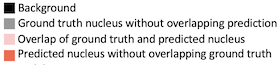

In [3]:
halfIoUThresh(root_dir=root_dir, regions_coordinate_dict=regions_coordinate_dict, save_qual_imgs=True, print_qual_imgs=False,
              platforms_list=platforms_list)

The function below generates one csv file for each WSI region/field containing the average F1-score over evaluation sub-regions for each platform and at varying IoU thresholds specified by <i>IoU_thresh_list</i> above. The csv files are saved in root/F1_multipleIoU_csv. It also has the functionality to generate qualitative visualizations (if save_qual_imgs set to True) of True Positive and False Positive predicted nuclei identified and True Positive and False Negative ground truth nuclei identified. These visualizations will be saved in root/qual_imgs/<b>Field1</b>/F1_visualization where <b>Field1</b> is replaced by the names of the WSI fields in root/fields. The legend below can be used to interpret these qualitative visualizations:


For predictions: 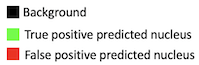


For ground truth: 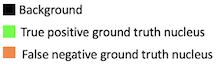


In [4]:
multipleIoUThresh(root_dir=root_dir, regions_coordinate_dict=regions_coordinate_dict, save_qual_imgs=True,
                  platforms_list=platforms_list, IoU_thresh_list=IoU_thresh_list)

<b>Quantitative evaluation visualization using csv files created</b>

The function below uses the csv files generated by the <i>halfIoUThresh</i> function above and saved in root/F1_halfIoU_csv to produce a barplot showing mean and 95% confidence interval (over evaluation sub-regions from all fields) of the F1-score of each platform on the entire dataset of  WSI regions in root/Fields. The barplot is saved in root/halfIoU_evaluation.

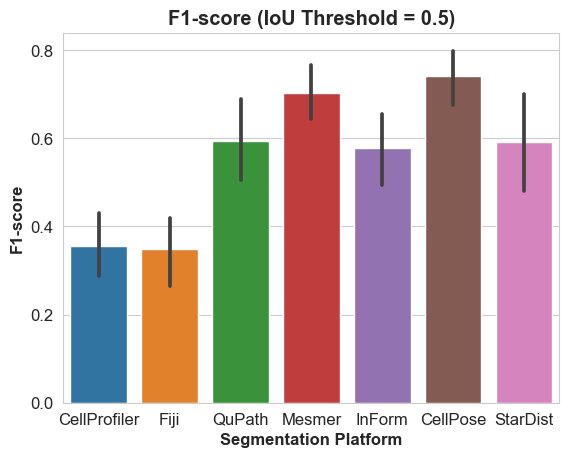

In [5]:
csv_viz_halfIoU(root_dir)

The function below uses the csv files generated by the <i>multipleIoUThresh</i> function above and saved in root/F1_multipleIoU_csv to produce a lineplot showing mean (over evaluation sub-regions from all fields) of the F1-score of each platform, calculated at varying IoU thresholds specified by <i>IoU_thresh_list</i> above, on the entire dataset of  WSI regions in root/Fields. The lineplot is saved in root/multipleIoU_evaluation/multipleIoU_plot.

C:\Users\mrl\Desktop\nuclear_seg_github\nuclear_segmentation\evaluation\F1_calc.py:634: UserWarning: 
The markers list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  combined_F1_lineplot = sns.lineplot(


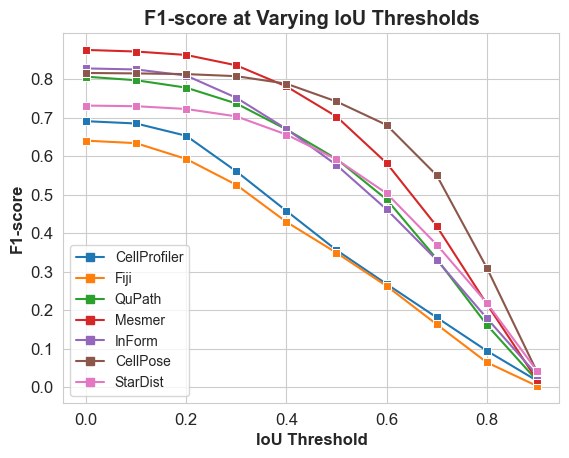

In [6]:
csv_viz_multipleIoU(root_dir)